In [6]:
!pip install implicit
!pip install faiss-cpu
!pip install implicit
!pip install fuzzywuzzy

In [4]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
import faiss
import implicit
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from fuzzywuzzy import process

C:\Users\kaush\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [5]:
data = pd.read_csv("books.csv", on_bad_lines='skip')

FileNotFoundError: [Errno 2] No such file or directory: 'books.csv'

In [43]:
data['genre'] = data['genre'].fillna('Unknown')
data['rating'] = data['rating'].fillna(data['rating'].mean())
data['author'] = data['author'].fillna('Unknown')
data['title'] = data['title'].fillna('Unknown')
data['img'] = data['img'].fillna('Unknown')
books = data.drop('pages', axis=1)
books['title'] = books['title'].str.lower().str.strip()
books['author'] = books['author'].str.lower().str.strip()

In [44]:
books['combined_features'] = books['title'] + " " + books['genre']

In [45]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(books['combined_features'])

In [46]:
svd = TruncatedSVD(n_components=200)
tfidf_reduced = svd.fit_transform(tfidf_matrix)

In [47]:
def get_content_recommendations(title, books, tfidf_reduced, top_n=10):
    matched_books = books[books['title'].str.contains(title, case=False, na=False)]
    if not matched_books.empty:
        book_idx = matched_books.index[0]
        cosine_sim = cosine_similarity([tfidf_reduced[book_idx]], tfidf_reduced).flatten()
        similar_indices = cosine_sim.argsort()[-top_n-1:-1][::-1]
        similar_books = books.iloc[similar_indices]
        return similar_books[['title', 'author', 'genre', 'rating']]
    return None

In [48]:
def get_similar_titles(title, books, limit=3):
    titles = books['title'].tolist()
    closest_matches = process.extract(title, titles, limit=limit)
    return [match[0] for match in closest_matches]

In [49]:
def prepare_collab_data(books):
    books['user_id'] = 0  # Dummy user for simplicity
    user_item_matrix = pd.pivot_table(books, values='rating', index='user_id', columns='title').fillna(0)
    sparse_matrix = csr_matrix(user_item_matrix.values)
    return sparse_matrix, user_item_matrix

In [50]:
def train_als_model(sparse_matrix):
    model = implicit.als.AlternatingLeastSquares(factors=50, regularization=0.1, iterations=10)
    model.fit(sparse_matrix.T)
    return model

In [51]:
def get_als_recommendations(model, user_item_matrix, title, n_recommendations=5):
    if title not in user_item_matrix.columns:
        return None  # Return None if the title is not found

    title_idx = user_item_matrix.columns.get_loc(title)
    scores = model.recommend(0, user_item_matrix.values[title_idx], N=n_recommendations)
    recommended_indices = [i[0] for i in scores]
    recommendations = user_item_matrix.columns[recommended_indices]
    return recommendations

In [52]:
# Backend Code
def get_hybrid_recommendations(title, genre, books, tfidf_reduced, als_model, user_item_matrix, n_recommendations=5):
    # Handle the case where title might be empty
    if not title:
        return "Please provide a book title."

    # Get content recommendations
    content_recommendations = get_content_recommendations(title, books, tfidf_reduced, top_n=n_recommendations)

    # Use fuzzy matching if no content recommendations found
    if content_recommendations is None:
        similar_titles = get_similar_titles(title, books)
        if similar_titles:
            title = similar_titles[0]  # Use first similar title for recommendations
            content_recommendations = get_content_recommendations(title, books, tfidf_reduced, top_n=n_recommendations)

    # Get collaborative recommendations
    collaborative_recommendations = get_als_recommendations(als_model, user_item_matrix, title, n_recommendations=n_recommendations)

    # Combine recommendations
    combined_recommendations = pd.DataFrame()

    if content_recommendations is not None:
        combined_recommendations = pd.concat([content_recommendations, pd.DataFrame({'title': collaborative_recommendations})]).drop_duplicates()
    
    return combined_recommendations.head(n_recommendations) if not combined_recommendations.empty else "No recommendations available."

# Main logic to prepare data and call the recommendation function
if __name__ == "__main__":
    # Load data and prepare collaborative filtering data
    sparse_matrix, user_item_matrix = prepare_collab_data(books)
    als_model = train_als_model(sparse_matrix)

    # Here you would not call the recommendation function directly; it should be called from Streamlit

In [53]:
def plot_rating_distribution(books):
    plt.figure(figsize=(10, 6))
    sns.histplot(books['rating'], bins=20, kde=True)
    plt.title('Distribution of Book Ratings')
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
    plt.show()

def plot_top_authors(books, n=10):
    top_authors = books['author'].value_counts().head(n)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=top_authors.index, y=top_authors.values, palette='viridis')
    plt.title(f'Top {n} Authors by Number of Books')
    plt.xlabel('Author')
    plt.ylabel('Number of Books')
    plt.xticks(rotation=45)
    plt.show()

def plot_top_genres(books, n=10):
    top_genres = books['genre'].value_counts().head(n)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=top_genres.index, y=top_genres.values, palette='plasma')
    plt.title(f'Top {n} Genres by Number of Books')
    plt.xlabel('Genre')
    plt.ylabel('Number of Books')
    plt.xticks(rotation=45)
    plt.show()

def plot_recommendations(recommendations):
    plt.figure(figsize=(12, 6))
    sns.barplot(x='title', y='rating', data=recommendations, palette='crest')
    plt.title('Top Recommended Books')
    plt.xlabel('Book Title')
    plt.ylabel('Rating')
    plt.xticks(rotation=45)
    plt.show()

Enter the book title: harry
Enter the book genre: fantasy


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.0006394386291503906 seconds
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]


Hybrid Recommendations:
                    title         author  \
73255         stork naked  piers anthony   
73287           pet peeve  piers anthony   
73442         the dastard  piers anthony   
73402        yon ill wind  piers anthony   
73434  golem in the gears  piers anthony   

                                                   genre  rating  
73255  Fantasy,Fiction,Humor,Science Fiction Fantasy,...    3.88  
73287  Fantasy,Fiction,Humor,Science Fiction Fantasy,...    3.87  
73442  Fantasy,Fiction,Humor,Science Fiction Fantasy,...    3.81  
73402  Fantasy,Fiction,Humor,Science Fiction Fantasy,...    3.76  
73434  Fantasy,Fiction,Humor,Science Fiction Fantasy,...    3.70  


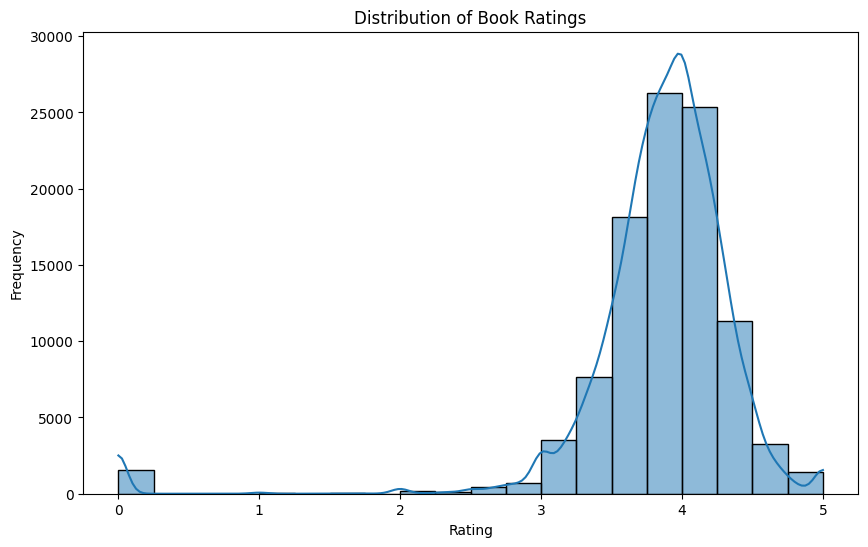

<ipython-input-53-ae5634dd6c72>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_authors.index, y=top_authors.values, palette='viridis')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping wi

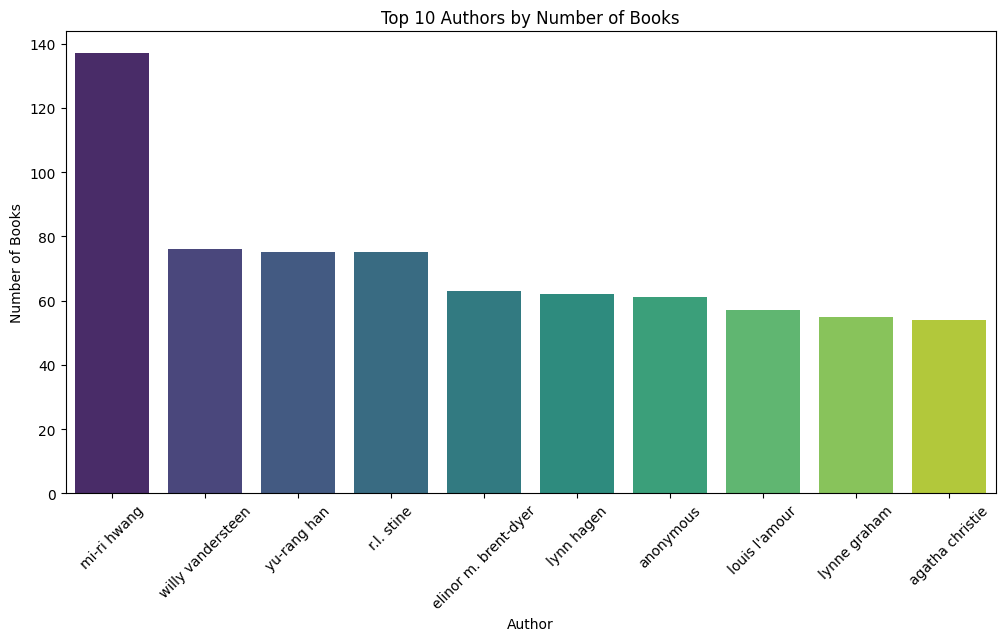

<ipython-input-53-ae5634dd6c72>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_genres.index, y=top_genres.values, palette='plasma')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with 

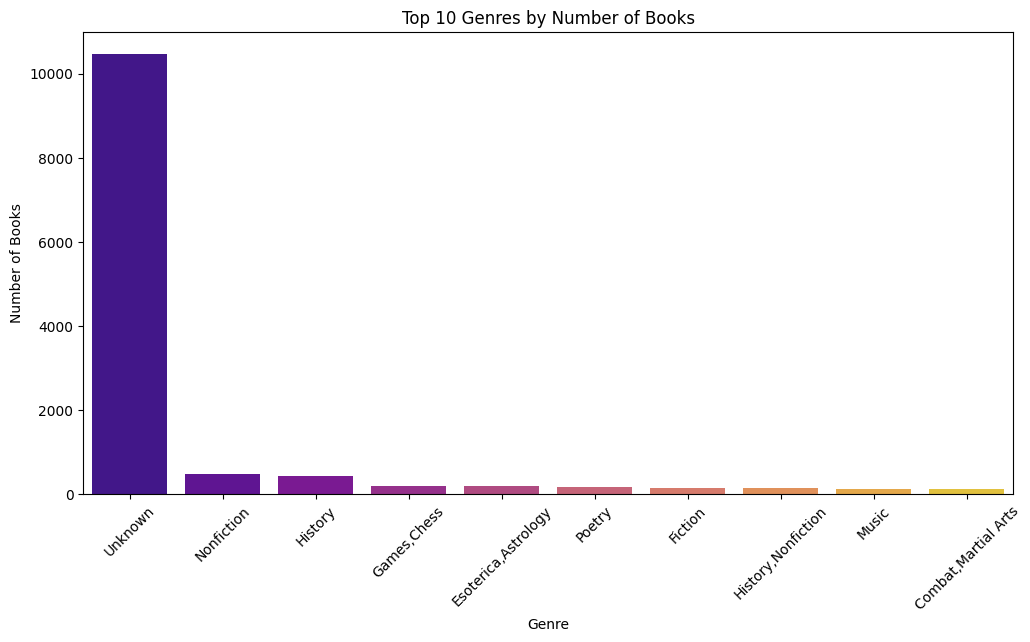

<ipython-input-53-ae5634dd6c72>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='title', y='rating', data=recommendations, palette='crest')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping wi

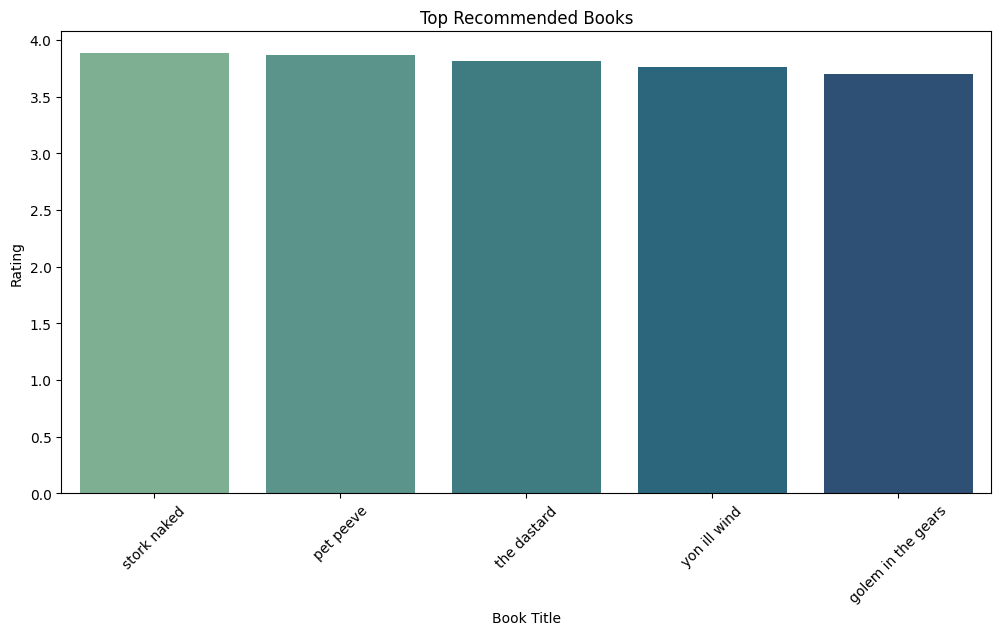

Enter the book title: harry
Enter the book genre: fantasy


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.0006778240203857422 seconds
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]


Error: The book title 'harry' is not found in the dataset.


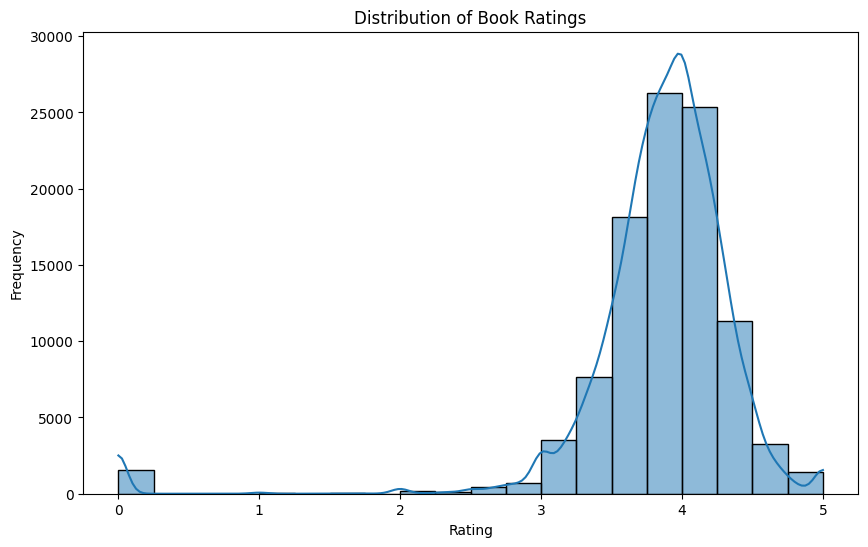

<ipython-input-20-ae5634dd6c72>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_authors.index, y=top_authors.values, palette='viridis')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping wi

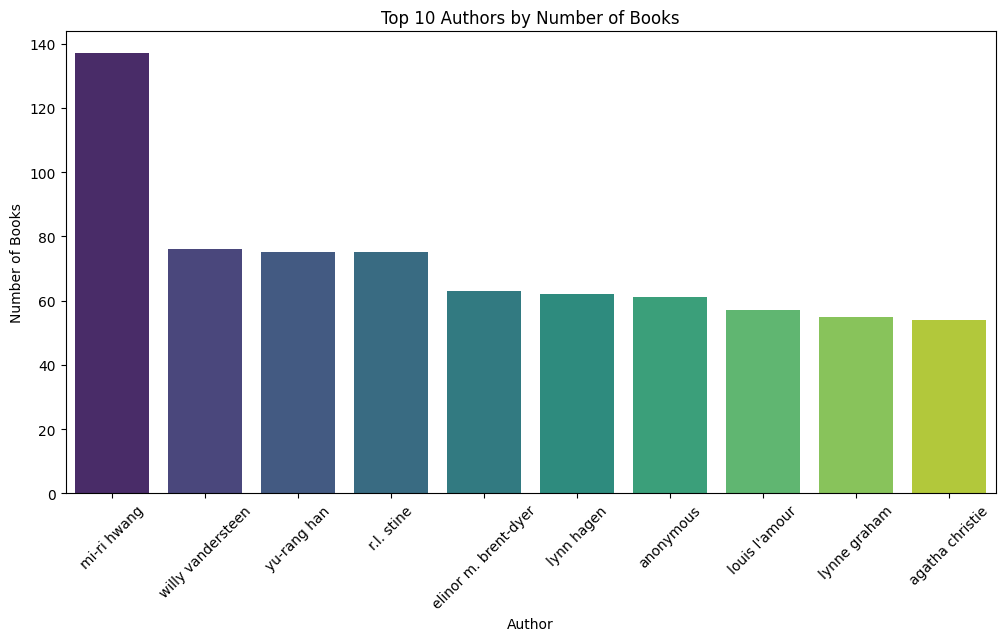

<ipython-input-20-ae5634dd6c72>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_genres.index, y=top_genres.values, palette='plasma')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with 

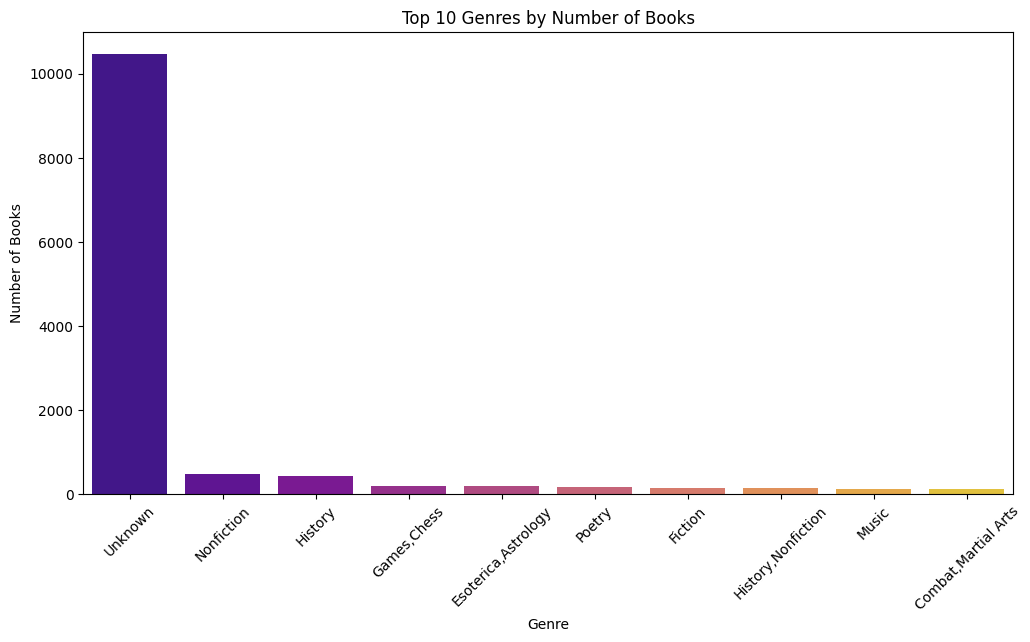